# RNN

In [5]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

## テストデータ生成

ノイズありの波を生成

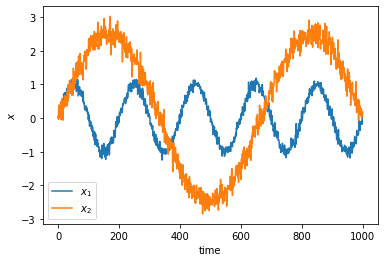

In [33]:
N = 1000
A, B = 1.0, 2.5   # 振幅
An, Bn = 0.1, 0.2  # ノイズの振幅

x = np.concatenate([
    A*np.sin(np.linspace(0, 10*np.pi, N)) + An*np.random.randn(N),
    B*np.sin(np.linspace(0, 3*np.pi, N)) + Bn*np.random.randn(N),
]).reshape(2, N).T

plt.xlabel('time')
plt.ylabel('$x$')
plt.plot(range(x.shape[0]), x[:,0], label='$x_1$')
plt.plot(range(x.shape[0]), x[:,1], label='$x_2$')
plt.legend()

plt.show()

## RNN の理論

全てのベクトルは行ベクトルであるとする。

$$
\boldsymbol{m_t}
\equiv
\boldsymbol{h}_{t-1} W_{\boldsymbol{h}} +
\boldsymbol{x}_t W_{\boldsymbol{x}} +
\boldsymbol{b}
$$

と置けば、

$$
\boldsymbol{h}_t
=
\tanh{\boldsymbol{m_t}}
$$

$$
m_{t,i}
=
\sum_k h_{t-1,k} W_{\boldsymbol{h}, ki} +
\sum_l x_{t,l} W_{\boldsymbol{x}, li} + b_i
$$

$$
h_{t,i}
=
\displaystyle
\tanh m_{t,i}
$$

後で使うので $$m_{t,i}$$ の微分を計算しておく：

$$
\begin{cases}
\cfrac{\partial m_{t,i}}{\partial h_{t-1,j}} &= W_{\boldsymbol{h},ji}
\\
\cfrac{\partial m_{t,i}}{\partial x_{t,j}} &= W_{\boldsymbol{x},ji}
\\
\cfrac{\partial m_{t,i}}{\partial W_{\boldsymbol{h},jk}} &= h_{t-1,j} \delta_{ik}
\\
\cfrac{\partial m_{t,i}}{\partial W_{\boldsymbol{x},jk}} &= x_{t,j} \delta_{ik}
\\
\cfrac{\partial m_{t,i}}{\partial b_{j}} &= \delta_{ij}
\end{cases}
$$

誤差逆伝播を考える。

$$
\begin{eqnarray}
\cfrac{\partial J}{\partial h_{t-1,i}}
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial h_{t,j}}{\partial h_{t-1,i}}
\\
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial}{\partial h_{t-1,i}} \tanh m_{t,j}
\\
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
\cfrac{\partial m_{t,j}}{\partial h_{t-1,i}}
\\
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
W_{\boldsymbol{h}, ij}
\\
&=&
\left\{
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
W_{\boldsymbol{h}}^{\rm T}
\right\}_{i}
\end{eqnarray}
$$

同様に、

$$
\cfrac{\partial J}{\partial x_{t,i}}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial h_{t,j}}{\partial x_{t,i}}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
\cfrac{\partial m_{t,j}}{\partial x_{t,i}}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
W_{\boldsymbol{x}, ij}
=
\left\{
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
W_{\boldsymbol{x}}^{\rm T}
\right\}_{i}
$$

$$
\cfrac{\partial J}{\partial W_{\boldsymbol{h},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\cfrac{\partial h_{t,k}}{\partial W_{\boldsymbol{h},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\left( 1 - \tanh^2 m_{t,k} \right)
\cfrac{\partial m_{t,k}}{\partial W_{\boldsymbol{h},ij}}
=
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
h_{t-1,i}
=
\left\{
\boldsymbol{h}_{t-1}^{\rm T}
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
\right\}_{ij}
$$

$$
\cfrac{\partial J}{\partial W_{\boldsymbol{x},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\cfrac{\partial h_{t,k}}{\partial W_{\boldsymbol{x},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\left( 1 - \tanh^2 m_{t,k} \right)
\cfrac{\partial m_{t,k}}{\partial W_{\boldsymbol{x},ij}}
=
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
x_{t,i}
=
\left\{
\boldsymbol{x}_t^{\rm T}
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
\right\}_{ij}
$$

$$
\cfrac{\partial J}{\partial b_i}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial h_{t,j}}{\partial b_i}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
\cfrac{\partial m_{t,j}}{\partial b_i}
=
\cfrac{\partial J}{\partial h_{t,i}}
\left( 1 - \tanh^2 m_{t,i} \right)
=
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)_{i}
$$

In [144]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        """
        Wh : hの重み
        Wx : xの重み
        b  : バイアス
        """
        self.Wh = Wh  # 全てのRNNブロックで同一の重みを共有
        self.Wx = Wx  # 全てのRNNブロックで同一の重みを共有
        self.b = b    # 全てのRNNブロックで同一の重みを共有
        self.grads = [
            np.zeros_like(Wx),
            np.zeros_like(Wh),
            np.zeros_like(b)
        ]             # 各RNNブロックが個別に保有
        self.cache = None
    
    def forward(self, X, Hprev, is_training=False):
        """
        X : その時刻の入力（行ベクトルを積んだ行列）
        H : 1つ前の時刻の出力（行ベクトルを積んだ行列）
        """
        H = np.tanh(np.dot(X, self.Wx) + np.dot(Hprev, self.Wh) + self.b)
        if is_training:
            self.cache = (X, H, Hprev)
        return H
    
    def backward(self, dH):
        X, H, Hprev = self.cache
        self.cache = 0
        tmp = dH * (1.0 - H * H)
        
        dX = np.dot(tmp, self.Wx.T)
        dHprev = np.dot(tmp, self.Wh.T)
        dWx = np.dot(X.T, tmp)
        dWh = np.dot(Hprev.T, tmp)
        db = tmp.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dX, dHprev


class TimeRNN:
    """
    Trancated BPTT を行う際の1セットを表すレイヤ
    """
    def __init__(self, Wx, Wh, b, stateful=False):
        """
        stateful : 次の TimeRNN レイヤへ隠れ状態Hを引き継ぐかどうか
        """
        self.params = [Wx, Wh, b]
        self.grads = [
            np.zeros_like(Wx),
            np.zeros_like(Wh),
            np.zeros_like(b)
        ]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
    
    def forward(self, xs, is_training=False):
        """
        Xs : データサンプル
            - D次元のデータサンプルを
            - 時系列にT個並べたものを
            - N個のバッチにまとめた3次元配列
        """
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        for t in range(T):
            layer = RNN(Wx, Wh, b)
            self.h = layer.forward(xs[:, t, :], self.h, is_training)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        
        return hs
            
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs


class Affine:
    def __init__(self, W, b):
        # モデルの重み
        self.params = [W, b]
        # 重みの勾配
        self.grads = [np.empty_like(W), np.empty_like(b)]
        # 誤差逆伝播用の中間データ
        self.cache = None

    def forward(self, X, is_training=False):
        W, b = self.params
        out = np.dot(X, W) + b
        
        if is_training:
            self.cache = X
        return out

    def backward(self, dout):
        W, b = self.params
        X = self.cache
        self.cache = None

        dX = np.dot(dout, W.T)
        dW = np.dot(X.T, dout)
        db = dout.sum(axis=0)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dX


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.empty_like(W), np.empty_like(b)]
        self.cache = None
    
    def forward(self, xs, is_training=False):
        W, b = self.params
        N, T, D = xs.shape
        D, H = W.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        for t in range(T):
            layer = Affine(W, b)
            h = layer.forward(xs[:, t, :], is_training)
            hs[:, t, :] = h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        W, b = self.params
        N, T, H = dhs.shape
        D, H = W.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        grads = [0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx = layer.backward(dhs[:, t, :])
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        return dxs


class LeastSquareLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, X_pred, X_corr, is_training=False):
        X_err = X_pred - X_corr
        cost = (X_err*X_err).sum()
        if is_training:
            self.cache = X_err
        return cost
    
    def backward(self, dout=1.0):
        X_err = self.cache
        batch_size = X_err.shape[0]
        self.cache = None
        return 2 * X_err * dout / batch_size


class TimeLeastSquareLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, xs, xs_corr, is_training=False):
        N, T, D = xs.shape
        
        cost = 0
        self.layers = []
        for t in range(T):
            layer = LeastSquareLoss()
            cost += layer.forward(xs[:, t, :], xs_corr[:, t, :], is_training)
            self.layers.append(layer)
        
        if is_training:
            self.cache = (N, T, D)
        
        return cost
    
    def backward(self):
        N, T, D = self.cache
        dxs = np.empty((N, T, D), dtype='f')
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx = layer.backward()
            dxs[:, t, :] = dx
        
        return dxs


class SoftmaxWithLoss:
    def __init__(self):
        self.cache = None
        
    def forward(self, X, P_corr, is_training=False):
        P_pred = self.__softmax(X)
        cost = self.__calc_cost(P_pred, P_corr)
        if is_training:
            self.cache = (P_pred, P_corr)
        return cost
    
    def backward(self, dout=1.0):
        P_pred, P_corr = self.cache
        self.cache = None
        batch_size = P_corr.shape[0]
        dX = (P_pred - P_corr) * dout / batch_size
        return dX
    
    def __softmax(self, X):
        """
        X : 行ベクトルのデータサンプルを積み重ねた行列
        """
        expX = np.exp(X)
        return (expX.T / expX.sum(axis=1)).T
    
    def __calc_cost(self, P_pred, P_corr):
        """
        P_pred : 予測所属確率の行ベクトルを積み重ねた行列
        P_corr : 正解所属確率
        """
        cost = - np.sum(P_corr * np.log(P_pred) + (1.0 - P_corr) * np.log(1.0 - P_pred), axis=0)
        cost = np.average(cost)
        return cost


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, xs, P_corr, is_training=False):
        N, T, D = xs.shape
        
        cost = 0
        self.layers = []
        for t in range(T):
            layer = SoftmaxWithLoss(is_training)
            cost += layer.forward(xs[:, t, :], P_corr[:, t, :])
            self.layers.append(layer)
        
        if is_training:
            self.cache = (N, T, D)
        
        return cost
    
    def backward(self):
        N, T, D = self.cache
        dxs = np.empty((N, T, D), dtype='f')
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx = layer.backward()
            dxs[:, t, :] = dx
        
        return dxs
    

class RNNRegression:
    """
    回帰問題を解く
    """
    def __init__(self, eta, batch_size, T, H):
        """
        eta        : 学習率
        batch_size : ミニバッチ学習のバッチサイズ
        T          : Trancated BPTT を行う際の RNN ブロック数
        H          : RNN 隠れ状態のノード数
        """
        self.eta = eta
        self.batch_size = batch_size
        self.T = T
        self.H = H
                
        self.Wx = None
        self.Wh = None
        self.b = None
        self.Wa = None
        self.ba = None
        self.layers = None
        self.loss = None
        self.x_ave = None
        self.x_sd = None
            
    def train(self, x, epochs):
        """
        x      : 時系列データ
        epochs :
        """
        L, D = x.shape  # データ長, 次元
        
        # データの標準化
        if self.x_ave is None:
            x_ave = x.mean(axis=0)
            x_sd = x.std(axis=0)
            self.x_ave = x_ave
            self.x_sd = x_sd
        x_std = (x - self.x_ave) / self.x_sd
        #x_standardized = self.__standardize_data(x)
        
        x_prev = x_std[:-1]
        x_next = x_std[1:]
        
        self.__initialize_layers(D)

        # バッチデータの設定
        jump = (L - 1) // (self.batch_size + 1)  # 末尾を超えてしまわないようにする
        
        for t in range(epochs):
            # バッチデータ作成
            offset = np.random.randint(jump)
            batch_x_prev = np.empty((self.batch_size, self.T, D), dtype='f')
            batch_x_next = np.empty((self.batch_size, self.T, D), dtype='f')
            for i in range(self.batch_size):
                base = offset + i * jump
                batch_x_prev[i] = x_prev[offset:offset+self.T]
                batch_x_next[i] = x_next[offset:offset+self.T]
                offset += jump
            
            # forward propagation
            out = batch_x_prev
            out = self.layers[0].forward(out, is_training=True)
            out = self.layers[1].forward(out, is_training=True)
            loss = self.layers[2].forward(out, batch_x_next, is_training=True)
            self.loss.append(loss)
            
            # back propagation
            dout = self.layers[2].backward()
            dout = self.layers[1].backward(dout)
            dout = self.layers[0].backward(dout)
            
            # update params
            self.Wx -= self.eta * self.layers[0].grads[0]
            self.Wh -= self.eta * self.layers[0].grads[1]
            self.b -= self.eta * self.layers[0].grads[2]
            self.Wa -= self.eta * self.layers[1].grads[0]
            self.ba -= self.eta * self.layers[1].grads[1]
        
    def predict(self, x):
        """
        x : D次元のデータが時系列にT個並んだもの
        """
        T, D = x.shape
        x_std = (x - self.x_ave) / self.x_sd
        x_std = x_std.reshape(1, T, D)
        
        #N, T, D = x.shape
        #x_std = np.empty_like(x)
        #for t in range(T):
        #    x_std[:, t, :] = self.__standardize_data(x[:, t, :])
        
        layers = [
            TimeRNN(self.Wx, self.Wh, self.b, stateful=True),
            TimeAffine(self.Wa, self.ba)
        ]
        
        out = x_std
        for layer in layers:
            out = layer.forward(out)
        
        out = out.reshape(T, D)
        result = out * self.x_sd + self.x_ave
        #result = np.empty_like(out)
        #for t in range(T):
        #    result[:, t, :] = self.__unstandardize_data(out[:, t, :])
        
        #for n in range(N):
        #    print('----- {} -----'.format(n))
        #    for t in range(T):
        #        print(x[n, t, :], result[n, t, :])
        
        #return result[:, -1, :]
        return result[-1]
    
    def __standardize_data(self, x):
        """
        x : データ
        """
        if self.x_ave is None:
            x_ave = x.mean(axis=0)
            x_sd = x.std(axis=0)
            self.x_ave = x_ave
            self.x_sd = x_sd
        return (x - self.x_ave) / self.x_sd

    def __unstandardize_data(self, x_std):
        """
        x_std : 標準化されたデータ
        """
        x = x_std * self.x_sd + self.x_ave
        return x
    
    def __initialize_layers(self, D):
        if self.layers is not None:
            return
        H = self.H
        sigma = 0.01
        self.Wx = sigma * np.random.randn(D, H)
        self.Wh = sigma * np.random.randn(H, H)
        self.b = sigma * np.random.randn(H)
        self.Wa = sigma * np.random.randn(H, D)
        self.ba = sigma * np.random.randn(D)
        self.layers = [
            TimeRNN(self.Wx, self.Wh, self.b, stateful=True),
            TimeAffine(self.Wa, self.ba),
            TimeLeastSquareLoss()
        ]
        self.loss = []

12.092801362276077


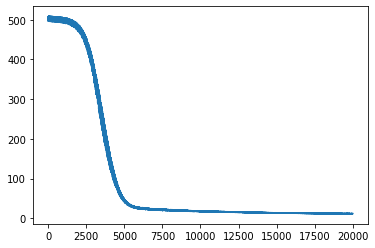

In [156]:
# 学習
N = 500
T = 50
A, B = 10.0, 2.5   # 振幅
#An, Bn = 0.1, 0.2  # ノイズの振幅
An, Bn = 0, 0
x = np.concatenate([
    A*np.sin(np.linspace(0, 30*np.pi, N)) + An*np.random.randn(N),
    B*np.sin(np.linspace(0, 17*np.pi, N)) + Bn*np.random.randn(N),
]).reshape(2, N).T
#x = np.array([range(100), range(100, 200)]).T

model = RNNRegression(eta=1.0e-5, batch_size=5, T=T, H=7)
model.train(x, 20000)
print(model.loss[-1])


# 学習曲線
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(model.loss)), model.loss)
plt.show()

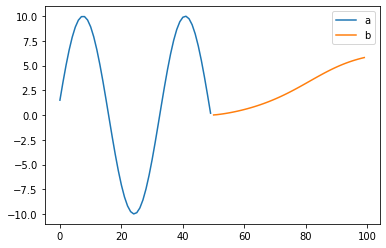

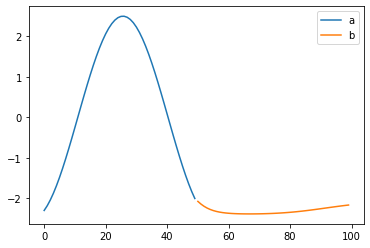

In [159]:
start = 400

x_in = x[start:start+T].copy()
x_pred = []
for _ in range(50):
    x_next = model.predict(x_in)
    x_pred.append(x_next)
    x_in[:-1] = x_in[1:]
    x_in[-1] = x_next
x_pred = np.array(x_pred)

plt.plot(range(T), x[start:start+T,0], label='a')
plt.plot(range(T, T+x_pred.shape[0]), x_pred[:,0], label='b')
plt.legend()
plt.show()

plt.plot(range(T), x[start:start+T,1], label='a')
plt.plot(range(T, T+x_pred.shape[0]), x_pred[:,1], label='b')
plt.legend()
plt.show()